
# Fisher Information — A Gentle, Practical Tour

> *“Information is what bends the curve.”*  
Think of Fisher Information as how **curved** your log-likelihood is around the true parameter. More curvature ⇒ more precision ⇒ less variance in your estimator.

This notebook walks you through:
- What Fisher Information is and why it shows up as the **curvature** of the log-likelihood.
- The two equivalent definitions (squared score vs. negative expected Hessian).
- **Observed** vs **Expected** information.
- Classic, crunchy examples (Bernoulli, Normal).
- The **Cramér–Rao Lower Bound (CRLB)** and how to read it.
- A quick numerical demo (finite differences & Monte Carlo).
- Short exercises you can run in class.

The tone aims for *Think Bayes 2*: friendly, direct, a bit witty, and highly hands-on.



## 1. Why “curvature” means “information”

Imagine the log-likelihood, $\ell(\theta) = \log L(\theta; x)$, as a hill over $\theta$.  
- The **peak** is your estimate.  
- The **steepness** around the peak tells how tightly the data pin down $\theta$.

If the hill is **narrow and steep**, nudging $\theta$ left or right drops the log-likelihood quickly.  
Data are very *sensitive* to $\theta$. That’s **high information**.

If the hill is **flat and wide**, many $\theta$ values fit almost equally well.  
Data are not very sensitive to $\theta$. That’s **low information**.

Mathematically, **curvature** is the second derivative. Fisher Information takes the **expected curvature** of $\ell(\theta)$ (or, equivalently, the expected squared slope), averaged over datasets generated at the true $\theta$.



## 2. Two equivalent definitions

Let $X \sim f(x \mid \theta)$. Define the **score** as the derivative of the log-likelihood:
$$
S(\theta; X) \;=\; \frac{d}{d\theta}\,\log f(X \mid \theta).
$$

Under standard regularity conditions, the **Fisher Information** is
$$
\boxed{\,I(\theta) \;=\; \mathbb{E}\!\left[S(\theta; X)^2\right] \;=\; -\,\mathbb{E}\!\left[\frac{d^2}{d\theta^2}\log f(X \mid \theta)\right]\,}
$$

- The expectation is with respect to $X \sim f(\cdot \mid \theta)$.
- The thing **inside** the expectation is sometimes called the **observed information** for the realized sample.
- The expectation itself gives the **Fisher Information** (a property of the model at $\theta$).



## 3. Observed vs Expected Information

- **Observed information** (for your actual dataset $x$) is the negative second derivative evaluated at $x$:
$$
J(\theta; x) \;=\; -\,\frac{d^2}{d\theta^2}\log f(x \mid \theta).
$$

- **Fisher (expected) information** averages the observed information over all possible $x$ generated at $\theta$:
$$
I(\theta) \;=\; \mathbb{E}\big[J(\theta; X)\big].
$$

Think: *Observed* = what your current sample says. *Expected* = what the data-generating process says **on average**.



## 4. Cramér–Rao Lower Bound (CRLB)

Fisher Information is the inverse of the best-possible variance—at least for unbiased estimators:
$$
\mathrm{Var}(\hat\theta) \;\ge\; \frac{1}{I(\theta)}.
$$

Big information $\Rightarrow$ small variance.  
Small information $\Rightarrow$ variance can’t be pushed much lower.



## 5. Example: Bernoulli($p$)

Let $X \in \{0,1\}$ with $P(X=1)=p$. One observation has
$$
\log f(x \mid p) \;=\; x\log p + (1-x)\log(1-p).
$$
The score is
$$
\frac{d}{dp}\log f(x \mid p) \;=\; \frac{x}{p} - \frac{1-x}{1-p}.
$$
Take the expectation over $X \sim \mathrm{Bernoulli}(p)$:
$$
I(p) \;=\; \mathbb{E}\!\left[\left(\frac{x}{p} - \frac{1-x}{1-p}\right)^2\right] \;=\; \frac{1}{p(1-p)}.
$$

For $n$ IID observations, information **adds**:
$$
I_n(p) \;=\; n \cdot \frac{1}{p(1-p)}.
$$

Information is highest near $p=0.5$, and lowest near 0 or 1.


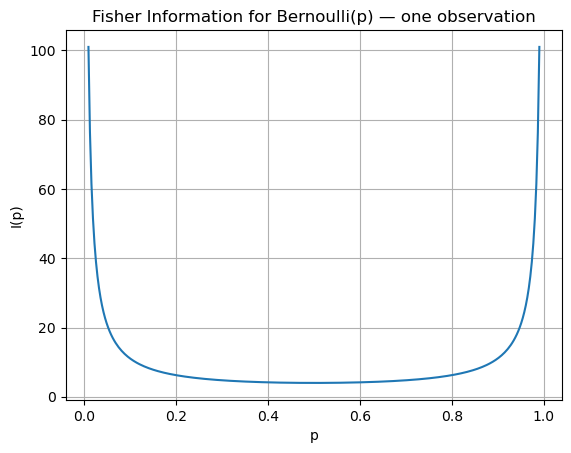

In [1]:

import numpy as np
import matplotlib.pyplot as plt

p = np.linspace(0.01, 0.99, 300)
I = 1.0/(p*(1-p))

plt.figure()
plt.plot(p, I)
plt.xlabel("p")
plt.ylabel("I(p)")
plt.title("Fisher Information for Bernoulli(p) — one observation")
plt.grid(True)
plt.show()



## 6. Example: Normal mean with known variance

Suppose $X \sim \mathcal{N}(\mu, \sigma^2)$ with **known** $\sigma^2$, and $\mu$ is the parameter.

$$
\log f(x \mid \mu) = -\frac{1}{2}\log(2\pi\sigma^2) - \frac{(x-\mu)^2}{2\sigma^2}.
$$
Score:
$$
\frac{d}{d\mu}\log f(x \mid \mu) = \frac{x - \mu}{\sigma^2}.
$$
Fisher Information (one observation):
$$
I(\mu) = \mathbb{E}\!\left[\left(\frac{x - \mu}{\sigma^2}\right)^2\right] = \frac{1}{\sigma^2}.
$$
For $n$ IID observations: $I_n(\mu) = \dfrac{n}{\sigma^2}$.

CRLB says $\mathrm{Var}(\hat\mu) \ge \sigma^2/n$.  
The sample mean actually **achieves** this bound (it’s efficient).


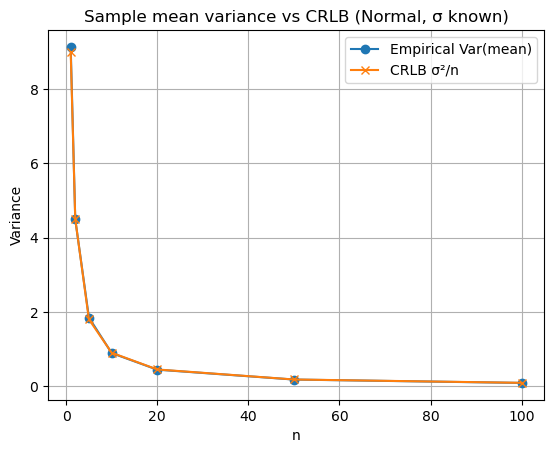

In [2]:

# Small numerical sanity check: as n grows, variance of the MLE ~ sigma^2/n
rng = np.random.default_rng(42)
mu_true = 2.0
sigma = 3.0
trials = 3000  # reduced a bit to keep execution snappy

def simulate_var(n):
    means = []
    for _ in range(trials):
        x = rng.normal(mu_true, sigma, size=n)
        means.append(np.mean(x))
    return np.var(means, ddof=1)

ns = np.array([1, 2, 5, 10, 20, 50, 100])
emp_var = np.array([simulate_var(int(n)) for n in ns])
theory = (sigma**2)/ns

import matplotlib.pyplot as plt
plt.figure()
plt.plot(ns, emp_var, marker="o", label="Empirical Var(mean)")
plt.plot(ns, theory, marker="x", label="CRLB σ²/n")
plt.xlabel("n")
plt.ylabel("Variance")
plt.title("Sample mean variance vs CRLB (Normal, σ known)")
plt.legend()
plt.grid(True)
plt.show()



## 7. When you don’t have a closed form: numeric approximations

Two handy strategies:

1. **Monte Carlo** (expected squared score):  
   - Draw $x^{(1)},\dots,x^{(M)} \sim f(\cdot \mid \theta)$.  
   - Compute the score $S(\theta; x^{(m)})$.  
   - Average $S^2$ across draws.

2. **Hessian (curvature) at the MLE**:  
   For large $n$, $-$ the Hessian of the log-likelihood at the MLE $\hat\theta$ approximates the **observed** information;  
   its expectation approximates Fisher information.

Below we do both for Bernoulli($p$), purely to show they agree with the closed-form $1/[p(1-p)]$.


In [3]:

import numpy as np

def bernoulli_score(x, p):
    return x/p - (1-x)/(1-p)

def fisher_mc_bernoulli(p, M=150000, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    xs = rng.binomial(1, p, size=M)
    s = bernoulli_score(xs, p)
    return np.mean(s**2)

for p in [0.2, 0.5, 0.8]:
    est = fisher_mc_bernoulli(p, M=150000, rng=np.random.default_rng(0))
    exact = 1/(p*(1-p))
    print(f"p={p:.1f}  MC≈{est:.5f}  exact={exact:.5f}")


p=0.2  MC≈6.19875  exact=6.25000
p=0.5  MC≈4.00000  exact=4.00000
p=0.8  MC≈6.19875  exact=6.25000


In [4]:

import numpy as np

def loglik_bernoulli(p, x):
    p = np.clip(p, 1e-12, 1-1e-12)  # guardrails
    return x*np.log(p) + (1-x)*np.log(1-p)

def hessian_fd_bernoulli(p, x, h=1e-5):
    # 1D second derivative via central differences
    l1 = loglik_bernoulli(p+h, x)
    l2 = loglik_bernoulli(p, x)
    l0 = loglik_bernoulli(p-h, x)
    second = (l1 - 2*l2 + l0)/(h**2)
    return second  # second derivative of loglik

# Observed information J = -d2/dp2 loglik
rng = np.random.default_rng(123)
p_true = 0.6
n = 3000
x = rng.binomial(1, p_true, size=n)
# Sum log-likelihood across samples, Hessian adds
second_sum = sum(hessian_fd_bernoulli(p_true, xi) for xi in x)
J_obs = -second_sum
I_theory = n/(p_true*(1-p_true))

print(f"Observed info (finite diff at true p) ≈ {J_obs:.3f}")
print(f"Theoretical Fisher info            = {I_theory:.3f}")


Observed info (finite diff at true p) ≈ 12336.805
Theoretical Fisher info            = 12500.000



## 8. Brief note: multivariate Fisher Information

If $\theta \in \mathbb{R}^k$, Fisher Information is a **matrix**:
$$
I(\theta) \;=\; \mathbb{E}\!\left[\,\nabla_\theta \log f(X\mid\theta)\;\nabla_\theta \log f(X\mid\theta)^\top\,\right]
\;=\; -\,\mathbb{E}\!\left[\,\nabla_\theta^2 \log f(X\mid\theta)\,\right].
$$

- Diagonals = information about each component (precision).  
- Off-diagonals = how parameters *interact* (curvature coupling).

In practice: invert $I(\theta)$ (or its plug-in estimate) to approximate the **asymptotic covariance** of MLEs.


## Excersice

In [6]:
# Given counts (n, k) from Bernoulli trials:
# n is the number of trials, here 50
# k is the number of successes, here 32
# 1) Compute the MLE (p_hat) p̂ = k/n.
# 2) Compute Fisher information for n trials: I_n(p̂) = n / [p̂ (1−p̂)].
# Run once, read the printed values, then fill STUDENT_* and re-run to check.

# Fill the following with the appropriate values instead of zeros:
n = 50
k = 32
p = (32/50)
I = 50 / [ * (1 - p)]

print(f"Counts: k={k}, n={n}")
print(f"p_hat = {p:.4f}")
print(f"Fisher info I_n(p_hat) = {I:.4f}")


TypeError: unsupported operand type(s) for /: 'int' and 'list'


## 10. Takeaways

- **Fisher Information = expected curvature** of the log-likelihood (or expected squared score).  
- It quantifies how **sensitive** the data are to $\theta$.  
- High information ⇒ **low variance** lower bound (CRLB).  
- For IID data, information usually **adds** linearly in $n$.  
- When algebra is messy, **simulate** (Monte Carlo) or **differentiate numerically** (Hessian) to approximate it.

If you keep only one mental picture: *steeper log-likelihood* = *more information* = *tighter estimates*.
